In [13]:
import sys
from io import StringIO
from gym.envs.toy_text import discrete
import numpy as np
from collections import defaultdict
from random import choice
import random
import seaborn
import matplotlib.pyplot as plt


In [23]:
NORTH = 0
EAST = 1
SOUTH = 2
WEST = 3

class Gridworld(discrete.DiscreteEnv): 
  metadata = {'render.modes': ['human', 'ansi']}
  def __init__(self, shape=[9, 9]):
    self.shape = shape
  
    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
        s = it.iterindex
        y, x = it.multi_index

        P[s] = {a: [] for a in range(nA)}

        # Build wall 
        self.wall = []
        self.block1 = np.array([3, 4, 5, 6, 7])
        self.block2 = np.array([2, 3, 4, 5])
        self.block3 = np.array([3, 4, 5, 6])
        self.build_wall()

        # Define snakepit and treasure 
        self.snakepit = self.shape[0] * 6 + 5  
        self.treasure = self.shape[0] * 8 + 8  

        if s == self.snakepit:reward = -50.0
        elif s == self.treasure: reward = 50.0
        else: reward = -1.0

        if s == self.snakepit:
            P[s][NORTH] = [(1.0, s, reward, True)]
            P[s][EAST] = [(1.0, s, reward, True)]
            P[s][SOUTH] = [(1.0, s, reward, True)]
            P[s][WEST] = [(1.0, s, reward, True)]
        else:   
            # Moving North 
            if y == 0 or (y == 2 and x in [2, 3, 4, 5, 6]) or (y == 8 and x in [1, 2, 3, 4]) or (y == 6 and x == 6):
                move_north = s
            else:
                move_north = s - MAX_X
            # Moving East 
            if x == (MAX_X - 1) or (y == 1 and x == 1) or (y == 7 and x == 0) or (x == 5 and y in [2, 3, 4, 5]):
                move_east = s
            else:
                move_east = s + 1
            # Moving South 
            if y == (MAX_Y - 1) or (y == 0 and x in [2, 3, 4, 5, 6]) or (y == 6 and x in [1, 2, 3, 4]):
                move_south = s
            else:
                move_south = s + MAX_X
            # Moving West
            if x == 0 or (y == 7 and x == 5) or (x == 7 and y in [1, 2, 3, 4, 5]):
                move_west = s
            else:
                move_west = s - 1

            P[s][NORTH] = [(1.0, move_north, reward, self.is_terminal(move_north))]
            P[s][EAST] = [(1.0, move_east, reward, self.is_terminal(move_east))]
            P[s][SOUTH] = [(1.0, move_south, reward, self.is_terminal(move_south))]
            P[s][WEST] = [(1.0, move_west, reward, self.is_terminal(move_west))]

        it.iternext()

    isd = np.ones(nS) / nS

    # Near by states 
    P[self.snakepit + 9][NORTH] = [(1.0, self.snakepit, -50.0, True)]
    P[self.snakepit - 1][EAST] = [(1.0, self.snakepit, -50.0, True)]
    P[self.snakepit - 9][SOUTH] = [(1.0, self.snakepit, -50.0, True)]
    P[self.snakepit + 1][WEST] = [(1.0, self.snakepit, -50.0, True)]
    P[self.treasure - 1][EAST] = [(1.0, self.treasure, 50.0, True)]
    P[self.treasure - 9][SOUTH] = [(1.0, self.treasure, 50.0, True)]
    self.P = P

    super(Gridworld, self).__init__(nS, nA, P, isd)

  def build_wall(self):
    for block in self.block1:
        self.wall.append(self.shape[0] * (2 - 1) + block - 1)
    for block in self.block2:
        self.wall.append(self.shape[0] * (8 - 1) + block - 1)   
    for block in self.block3:
        self.wall.append(self.shape[0] * (block - 1) + 7 - 1)
  

  def is_terminal(self, s):
      return True if s == self.snakepit or s == self.treasure else False

  def _render(self, mode='human', close=False):
      if close:
          return

      outfile = StringIO() if mode == 'ansi' else sys.stdout

      grid = np.arange(self.nS).reshape(self.shape)
      it = np.nditer(grid, flags=['multi_index'])
      while not it.finished:
          s = it.iterindex
          y, x = it.multi_index

          if self.s == s:
              output = " X " 
          elif self.is_terminal(s):
              output = " " + chr(9443) + ' '
          elif s in self.wall:
              output = " " + chr(9618) + ' '
          else:
              output = " . "

          if x == 0:
              output = output.lstrip()
          if x == self.shape[1] - 1:
              output = output.rstrip()

          outfile.write(output)

          if x == self.shape[1] - 1:
              outfile.write("\n")

          it.iternext()
      print("\n")

env = Gridworld((9, 9))
env._render(mode="human")


.  .  .  .  .  .  .  .  .
.  .  ▒  ▒  ▒  ▒  ▒  .  .
.  .  .  .  .  .  ▒  .  .
.  .  .  .  .  .  ▒  .  .
.  .  .  .  .  .  ▒  .  .
.  .  .  .  .  .  ▒  .  .
.  .  X  .  .  ⓣ  .  .  .
.  ▒  ▒  ▒  ▒  .  .  .  .
.  .  .  .  .  .  .  .  ⓣ




## Monte carlo evaluation

In [15]:
def generate_random_episode(env):
    episode = []
    done = False
    state = env.reset()
    episode.append((state, -1))
    while not done:
        action = choice(list(env.P[state].keys())) 
        next_state = env.P[state][action][0][1]
        reward = env.P[state][action][0][2]
        done = env.P[state][action][0][3]
        episode.append((next_state, reward))
        if next_state == 0:
            done = True
        state = next_state
    return episode

In [16]:
def monte_carlo(env, num_iter):
    values = np.zeros(env.observation_space.n) 
    returns = dict()
    for state in range(env.observation_space.n):
        returns[state] = list()
    
    for i in range(num_iter):
        episode = generate_random_episode(env)
        already_visited = set({0})  
        for s, r in episode:
            if s not in already_visited:
                already_visited.add(s)
                idx = episode.index((s, r))
                G = 0
                j = 1
                while j + idx < len(episode):
                    G = gamma * (G + episode[j + idx][1])
                    j += 1
                returns[s].append(G)
                values[s] = np.mean(returns[s])
    return values, returns
gamma = 1.0
values, returns = monte_carlo(env, 500)

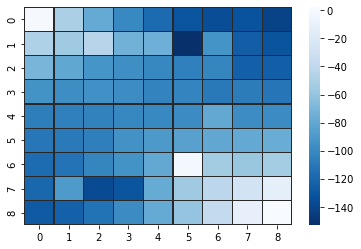

In [17]:
def show_values(values):
    values = values.reshape(env.shape)
    ax = seaborn.heatmap(values, cmap = "Blues_r", annot = False, linecolor="#282828", linewidths = 0.1)
    plt.show()
show_values(values)

## SARSA

In [29]:
def SARSA(env, discount, step_size, num_episodes):  
    states = env.P 
    actions = [0,1,2,3]
    values = defaultdict(dict)

    # creating random inital policy 
    for state in states:
        for action in actions:
            values[state][action] = random.uniform(0,1)

    for i in range(num_episodes):
        init_state = choice(list(set(env.P.keys())))
        init_action = max(values[init_state].items(), key=lambda a: a[1])[0] 
        
        while not env.is_terminal(init_state):
            reward = env.P[init_state][init_action][0][2]
            next_state = env.P[init_state][init_action][0][1]
            next_action = max(values[next_state].items(), key=lambda a: a[1])[0] 
            
            values[init_state][init_action] += step_size * (reward + discount * values[next_state][next_action]
                                                       - values[init_state][init_action])
            init_state = next_state
            init_action = next_action
        sys.stdout.flush()
    return values

sarsa_val = SARSA(env, 1.0, 0.9, 50000)    

In [71]:
def show_selected_actions(values): 
  count = 0 
  for j in range(9):
    layer = []
    for i in range(j,j+9):
      layer.append(max(values[count].items(), key=lambda a: a[1])[0])
      count +=1
    print(layer)

show_selected_actions(sarsa_val)

[1, 1, 1, 1, 1, 1, 1, 2, 2]
[2, 2, 1, 0, 1, 0, 1, 2, 2]
[2, 2, 2, 2, 2, 3, 1, 1, 2]
[2, 2, 3, 2, 3, 3, 1, 2, 3]
[2, 2, 3, 3, 2, 2, 1, 2, 2]
[1, 2, 3, 3, 2, 3, 2, 1, 2]
[2, 3, 3, 3, 3, 3, 2, 2, 2]
[2, 0, 0, 0, 1, 2, 1, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1]


## q learning 

In [73]:
def q_learning(env, discount, step_size, num_episodes):
    states = env.P 
    actions = [0,1,2,3]
    values = defaultdict(dict)

    # creating random inital policy 
    for state in states:
        for action in actions:
            values[state][action] = random.uniform(0,1)

    for i in range(num_episodes):
        init_state = choice(list(set(env.P.keys())))  
        while not env.is_terminal(init_state):
            init_action = max(values[init_state].items(), key=lambda a: a[1])[0]  
            reward = env.P[init_state][init_action][0][2]
            next_state = env.P[init_state][init_action][0][1]

            best_val = max(values[next_state].items(), key=lambda a: a[1])[1]
            values[init_state][init_action] += step_size * (reward + discount * best_val
                                                       - values[init_state][init_action])
            init_state = next_state
        sys.stdout.flush()
    return values

q_vals = q_learning(env, 1.0, 0.9, 50000)    


In [74]:
show_selected_actions(q_vals)

[1, 1, 1, 1, 1, 1, 1, 2, 2]
[1, 0, 0, 0, 0, 0, 3, 2, 2]
[2, 2, 2, 3, 2, 3, 1, 2, 2]
[2, 2, 2, 3, 2, 2, 1, 2, 2]
[2, 3, 3, 3, 3, 3, 1, 1, 2]
[2, 2, 3, 3, 2, 3, 1, 2, 2]
[2, 3, 3, 3, 3, 2, 1, 2, 2]
[2, 3, 0, 0, 2, 1, 1, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 0]
